Using device: cuda
Malicious client: [0]
Global Epoch 1/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 1: 96.43%
Global Epoch 2/15


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Detected malicious clients: [0]
Global Model Test Accuracy after round 2: 97.44%
Global Epoch 3/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 3: 97.94%
Global Epoch 4/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 4: 98.11%
Global Epoch 5/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 5: 98.27%
Global Epoch 6/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 6: 98.36%
Global Epoch 7/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 7: 98.45%
Global Epoch 8/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 8: 98.46%
Global Epoch 9/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 9: 98.54%
Global Epoch 10/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 10: 98.51%
Global Epoch 11/15
Detected malicious clients: [0]
Global Model Test Accuracy after round 11: 98.51%
Global Epoch 12/15
Detec

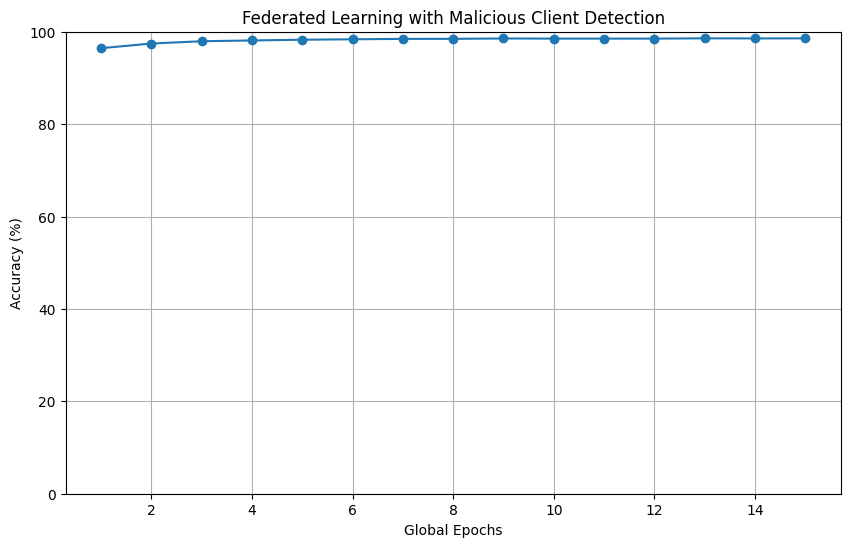

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from google.colab import files
from datetime import datetime

# Define the CNN Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Load MNIST dataset
def load_data(transform):
    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Partition the dataset for each client
def partition_dataset(dataset, n_clients=10):
    split_size = len(dataset) // n_clients
    return random_split(dataset, [split_size] * n_clients)

# Client-side local training
def client_update(client_model, optimizer, train_loader, device, epochs=1, is_malicious=False):
    client_model.train()
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            if is_malicious:
                for param in client_model.parameters():
                    param.data += torch.randn_like(param) * 10  # Inject random noise
            else:
                loss = nn.CrossEntropyLoss()(output, labels)
                loss.backward()
                optimizer.step()

# Detect malicious clients based on update norms
def detect_malicious_clients(client_models, global_model, threshold_factor=1.5):
    global_dict = global_model.state_dict()
    norms = []
    for i, client_model in enumerate(client_models):
        norm = 0
        client_dict = client_model.state_dict()
        for k in global_dict.keys():
            norm += torch.norm(global_dict[k] - client_dict[k]).item()
        norms.append(norm)
    mean_norm = torch.mean(torch.tensor(norms))
    std_norm = torch.std(torch.tensor(norms))
    threshold = mean_norm + threshold_factor * std_norm
    #print(f"Norms: {norms}")  # Debugging to log norms
    #print(f"Mean Norm: {mean_norm}, Std Norm: {std_norm}, Threshold: {threshold}")  # Threshold details
    return [i for i, norm in enumerate(norms) if norm > threshold]

# Robust aggregation using Trimmed Mean
def robust_aggregate(global_model, client_models, malicious_clients, trim_ratio=0.2):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        updates = [
            client_models[i].state_dict()[k] for i in range(len(client_models)) if i not in malicious_clients
        ]
        if updates:
            updates = torch.stack(updates)
            sorted_updates = torch.sort(updates, dim=0).values
            trim_count = int(len(updates) * trim_ratio)
            trimmed_updates = sorted_updates[trim_count:-trim_count]
            global_dict[k] = torch.mean(trimmed_updates, dim=0) if trimmed_updates.numel() > 0 else global_dict[k]
    global_model.load_state_dict(global_dict)

# Test the global model
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100

# Federated Learning Process
def federated_learning(n_clients=10, global_epochs=15, local_epochs=3, num_malicious=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset, test_dataset = load_data(transform)
    client_datasets = partition_dataset(train_dataset, n_clients)
    client_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    global_model = ConvNet().to(device)
    client_models = [copy.deepcopy(global_model) for _ in range(n_clients)]
    optimizers = [torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) for model in client_models]

    scheduler = torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=5, gamma=0.5)

    malicious_clients = random.sample(range(n_clients), num_malicious)
    print(f"Malicious client: {malicious_clients}")

    accuracy_values = []
    log_file = "federated_learning_level3.log"

    with open(log_file, "w") as log:
        for epoch in range(global_epochs):
            print(f"Global Epoch {epoch + 1}/{global_epochs}")
            log.write(f"Global Epoch {epoch + 1}/{global_epochs}\n")

            # Local updates
            for i in range(n_clients):
                client_update(
                    client_models[i], optimizers[i], client_loaders[i], device, local_epochs, is_malicious=(i in malicious_clients)
                )

            # Detect malicious clients
            detected_malicious = detect_malicious_clients(client_models, global_model)
            print(f"Detected malicious clients: {detected_malicious}")
            log.write(f"Detected malicious clients: {detected_malicious}\n")

            # Robust aggregation
            robust_aggregate(global_model, client_models, detected_malicious)

            # Test the global model
            test_accuracy = test_model(global_model, test_loader, device)
            accuracy_values.append(test_accuracy)
            print(f"Global Model Test Accuracy after round {epoch + 1}: {test_accuracy:.2f}%")
            log.write(f"Global Model Test Accuracy after round {epoch + 1}: {test_accuracy:.2f}%\n")

            scheduler.step()

    # Save the global model
    torch.save(global_model.state_dict(), "federated_mnist_level3_model.pth")
    print("Federated learning process completed. Model saved as 'federated_mnist_level3_model.pth'.")

    # Plot the accuracy graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, global_epochs + 1), accuracy_values, marker='o')
    plt.title("Federated Learning with Malicious Client Detection")
    plt.xlabel("Global Epochs")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig("level3_accuracy_graph.png")
    plt.show()

    return accuracy_values, log_file

# Download files
def download_files(log_file):
    files_to_download = ["federated_mnist_level3_model.pth", "level3_accuracy_graph.png", log_file]
    for file in files_to_download:
        if os.path.exists(file):
            files.download(file)

if __name__ == "__main__":
    accuracy_values, log_file = federated_learning(n_clients=10, global_epochs=15, local_epochs=3, num_malicious=1)
    download_files(log_file)
